# 5.1 합성곱 신경망

In [1]:
import keras
import tensorflow as tf
from keras import layers
from keras import models
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Using TensorFlow backend.


In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

In [5]:
# MNIST 이미지에 컨브넷 훈련하기
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.1604 - acc: 0.9495
Epoch 2/5
60000/60000 [==============================] - 7s 109us/step - loss: 0.0447 - acc: 0.9859
Epoch 3/5
60000/60000 [==============================] - 6s 101us/step - loss: 0.0307 - acc: 0.9904
Epoch 4/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.0235 - acc: 0.9929
Epoch 5/5
60000/60000 [==============================] - 6s 95us/step - loss: 0.0186 - acc: 0.9941


In [6]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("test loss : ", test_loss)
print("test accuracy : ", test_acc)

# 기본적인 ConvNet으로도 앞 장에서의 Fully Connected Network보다 높은 정확도 확보

10000/10000 [==============================] - 1s 95us/step
test loss :  0.03738682039966079
test accuracy :  0.989


## 5.1.1 합성곱 연산

* **Dense 층(완전 연결 층)**은 입력 특성 공간에 있는 **전역 패턴**을 학습  
* **합성곱 층**은 **지역 패턴**을 학습

#### **<컨브넷의 두 가지 성질>**

**1. 학습된 패턴은 Translation Invariant(평행 이동 불변성)을 가진다.**
    - 컨브넷이 이미지의 오른쪽 아래 모서리에서 패턴을 학습했다면 다른 곳에서도 이 패턴 인식 가능
    - 적은 수의 훈련 샌플을 사용해서 일반화 능력을 가진 표현을 학습할 수 있음  



**2. 컨브넷은 패턴의 공간적 계층 구조를 학습할 수 있다.**
    - 첫 번째 합성곱 층이 작은 지역 패턴 학습하고, 두 번째 층이 첫 번째 층의 특성으로 구성된 더 큰 패턴 학습
 

#### **<합성곱의 핵심 파라미터>**

- 입력으로부터 뽑아낼 패치의 크기 : 윈도우의 크기로, 보통 3x3 이나 5x5 크기 사용
- 특성 맵의 출력 깊이 : 합성곱으로 계산할 필터의 수

#### **<경계 문제와 패딩 이해하기>**

- 5x5의 입력이 있을 때 3x3의 필터를 사용하면 필터의 중앙에 입력값이 들어가도록 만드는 경우의 수가 최대 9개 이므로
  최종 출력 특성 맵이 3x3으로 입력 특성 맵에 비해 높이, 넓이가 줄어든다.  
<br>
- 이를 해결하고자 입력 특성 맵의 가장자리에 적절한 개수의 행과 열을 추가하면 필터의 중앙에 입력값이 들어가는 더 많은 경우가 생겨나고
  입력 특성 맵과 크기가 같은 출력 특성 맵을 만들 수 있다.

#### **<합성곱 스트라이드>**
- 구글링
- 윈도우의 중앙에 오는 원본 파일 cell을 1칸씩이 아닌 설정된 stride 만큼씩 넘기는 개념인 듯

## 5.1.2 Max Pooling

- 스트라이드 합성곱과 유사하게 <u>**강제적으로 특성 맵을 다운샘플링하는 것이 최대 풀링의 역할**</u>
- 입력 특성 맵에서 윈도우에 맞는 패치를 추출하고 각 <u>채널별로 최댓값을 출력</u>
- 합성곱과의 가장 큰 차이점은 보통 2x2 윈도우와 스트라이드 2를 사용해 <u>특성 맵을 절반 크기로 다운샘플링 한다는 점</u>  
  -> **why?** 처리할 특성 맵의 가중치 개수를 줄이기 위해(다운샘플링 없이 Conv2D 층 3개로 연결한 후 최종 특성 맵을 펼치고  
     Dense 층과 연결하면 엄청난 수의 가중치 파라미터가 생김)  
     또한, 세 번째 층의 윈도우가 초기 입력의 일부 영역에 대한 정보만을 담고 있는 등 특성의 공간적 계층 구조 학습이 되지 않음(교재 181p) -> why....?

# 5.2 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기

1. 보유한 소규모 데이터셋을 사용하여 어떤 규제도 사용하지 않고 훈련하여 기준이되는 기본 성능의 컨브넷 만들기
2. 과대적합을 줄이기 위한 Data Augmentation(데이터 증식) 적용
3. 사전 훈련된 네트워크로 특성을 추출
4. 사전 훈련된 네트워크를 세밀하게 튜닝

## 5.2.2 데이터 내려받기

In [7]:
import os, shutil

original_dataset_dir = './datasets/cats_and_dogs/train'

base_dir = './datasets/cats_and_dogs_small'
#os.mkdir(base_dir)

In [8]:
train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'validation')
#os.mkdir(val_dir)
test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
#os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
#os.mkdir(train_dogs_dir)
val_cats_dir = os.path.join(val_dir, 'cats')
#os.mkdir(val_cats_dir)
val_dogs_dir = os.path.join(val_dir, 'dogs')
#os.mkdir(val_dogs_dir)
test_cats_dir = os.path.join(test_dir, 'cats')
#os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
#os.mkdir(test_dogs_dir)

In [8]:
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames: 
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    # 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames: 
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(val_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames: 
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames: 
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames: 
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(val_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames: 
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

## 5.2.3 네트워크 구성하기

- 이미지가 크고 복잡하므로 네트워크 용량을 크게 만듦
- Conv2D + MaxPooling2D 세트를 추가
  - 네트워크 용량이 늘어나고, Flatten 층의 크기가 너무 커지지 않도록 특성 맵 크기 줄일 수 있음

In [9]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [11]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

## 5.2.4 데이터 전처리

1. 사진 파일 읽기
2. JPEG 콘텐츠 to RGB 픽셀 값 decoding
3. 부동 소수 타입의 텐서로 변환
4. 픽셀 값(0~255)의 스케일을 [0,1] 사이로 조정

In [12]:
# 케라스에는 위 작업을 자동으로 처리해주는 라이브러리 존재
from keras.preprocessing.image import ImageDataGenerator as IDG

train_datagen = IDG(rescale=1./255)
test_datagen = IDG(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, #타깃 디렉토리
    target_size=(150,150), # 150x150으로 변환
    batch_size=20,
    class_mode='binary')

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기 : ', data_batch.shape)
    print('배치 레이블 크기 : ', labels_batch.shape)
    break

배치 데이터 크기 :  (20, 150, 150, 3)
배치 레이블 크기 :  (20,)


In [14]:
# batch generator를 사용하여 모델 훈련하기
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, # 하나의 에포크에서 사용할 샘플의 개수
    epochs=30,
    validation_data=val_generator,
    validation_steps=50)

model.save('cats_and_dogs_small_1.h5')

Epoch 1/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6903 - acc: 0.5255 - val_loss: 0.6733 - val_acc: 0.5260
Epoch 2/30
100/100 [==============================] - 4s 42ms/step - loss: 0.6543 - acc: 0.6095 - val_loss: 0.6280 - val_acc: 0.6640
Epoch 3/30
100/100 [==============================] - 4s 40ms/step - loss: 0.6058 - acc: 0.6685 - val_loss: 0.6230 - val_acc: 0.6410
Epoch 4/30
100/100 [==============================] - 4s 41ms/step - loss: 0.5690 - acc: 0.7000 - val_loss: 0.6096 - val_acc: 0.6630
Epoch 5/30
100/100 [==============================] - 4s 42ms/step - loss: 0.5446 - acc: 0.7215 - val_loss: 0.5941 - val_acc: 0.6900
Epoch 6/30
100/100 [==============================] - 4s 40ms/step - loss: 0.5236 - acc: 0.7320 - val_loss: 0.5848 - val_acc: 0.6630
Epoch 7/30
100/100 [==============================] - 4s 40ms/step - loss: 0.4960 - acc: 0.7515 - val_loss: 0.5810 - val_acc: 0.6990
Epoch 8/30
100/100 [==============================] - 4s 42ms/step - 

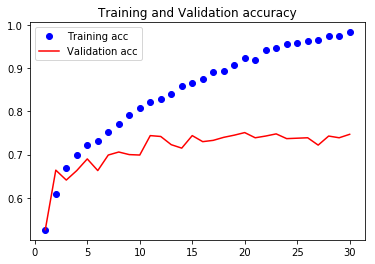

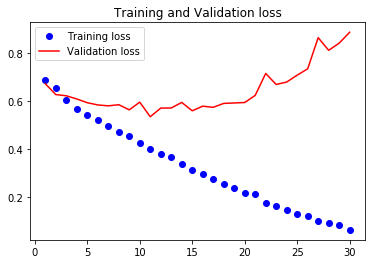

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure().patch.set_facecolor('xkcd:white')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure().patch.set_facecolor('xkcd:white')

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()
# 전형적인 과대적합의 특성을 보여줌
# 검증 정확도는 10번째 에포크에서 74% 달성 후 더 나아지지 않음
# 검증 손실 또한 9번째 정도에서 최솟값 달성 후 더 이상 진전x. 점점 증가
# 반면 훈련 손실은 0에 다다를 때까지 선형적으로 지속 감소
# 과대적합 감소 기법으로 'Data Augmentation' 사용

## 5.2.5 Data Augmentation(데이터 증식) 사용

- 과대적합 : 학습할 샘플이 너무 적어 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기 때문에 발생
- 데이터 증식 : 데이터를 증식시켜 충분한 훈련 데이터를 생성
- 그럴듯한 이미지를 생성하도록 여러 가지 랜덤한 변환을 적용하여 샘플을 늘림
- 목표 : 훈련할 때 모델이 정확히 같은 데이터를 두 번 만나지 않도록 하는 것

In [21]:
datagen = IDG(
    rotation_range=20, # 랜덤하게 사진을 회전시킬 각도의 범위
    width_shift_range=0.1, # 수평 랜덤 평행 이동
    height_shift_range=0.1, # 수직 랜덤 평행 이동
    shear_range=0.1, # 랜덤 전단 변환(rotation_range로 회전할 때, y축 방향으로 각도를 증가시켜 이미지를 변형)
    zoom_range=0.1, # 랜덤 확대
    horizontal_flip=True, # 랜덤 수평 뒤집기
    fill_mode='nearest') # 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략

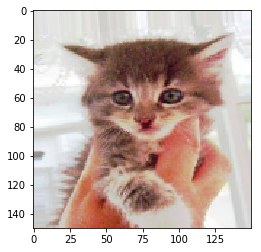

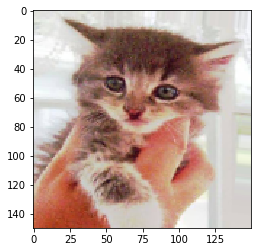

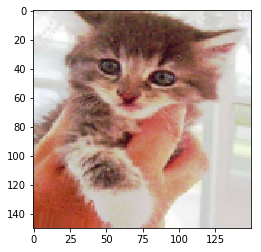

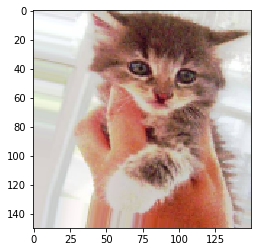

In [28]:
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for
                fname in os.listdir(train_cats_dir)])

img_path = fnames[3] # 증식할 이미지 선택

img = image.load_img(img_path, target_size=(150,150))

x = image.img_to_array(img) # (150,150,3) 크기 배열로 변환
x = x.reshape((1,) + x.shape) # (1,150,150,3) 크기로 변환

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i).patch.set_facecolor('xkcd:white')
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    z += 1
    if i % 4 == 0:
        break
plt.show()
    

In [30]:
# 적은 수의 원본 이미지에서 만들어졌으므로 여전히 입력 데이터 사이에 상호 연관성이 큼.
# 과대적합을 더 억제하기 위해 완전 연결 분류기(Dense 층) 직전에 Dropout 층 추가
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                       input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                 optimizer=optimizers.RMSprop(lr=1e-4),
                 metrics=['acc'])

In [34]:
train_datagen = IDG(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = IDG(rescale=1./255) # 검증 데이터 및 테스트 데이터는 증식되면 안됨!!!

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150,150),
                    batch_size=32,
                    class_mode='binary')
val_generator = test_datagen.flow_from_directory(
                    val_dir,
                    target_size=(150,150),
                    batch_size=32,
                    class_mode='binary')
history = model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=100,
            validation_data=val_generator,
            validation_steps=50)

model.save('cats_and_dogs_small_2.h5')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 28s 276ms/step - loss: 0.6886 - acc: 0.5262 - val_loss: 0.6702 - val_acc: 0.5749
Epoch 2/100
100/100 [==============================] - 22s 220ms/step - loss: 0.6771 - acc: 0.5688 - val_loss: 0.6599 - val_acc: 0.5767
Epoch 3/100
100/100 [==============================] - 21s 206ms/step - loss: 0.6645 - acc: 0.5834 - val_loss: 0.6390 - val_acc: 0.6478
Epoch 4/100
100/100 [==============================] - 23s 231ms/step - loss: 0.6496 - acc: 0.6150 - val_loss: 0.6237 - val_acc: 0.6591
Epoch 5/100
100/100 [==============================] - 23s 230ms/step - loss: 0.6261 - acc: 0.6434 - val_loss: 0.6109 - val_acc: 0.6618
Epoch 6/100
100/100 [==============================] - 23s 230ms/step - loss: 0.6190 - acc: 0.6469 - val_loss: 0.5840 - val_acc: 0.6849
Epoch 7/100
100/100 [==============================] - 22s 216ms/step - loss: 0.6114 - acc: 0.6509 -

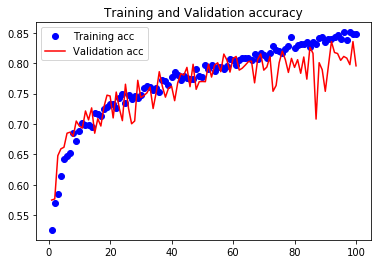

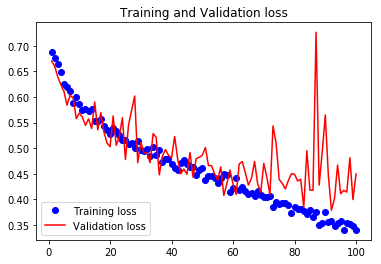

In [35]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure().patch.set_facecolor('xkcd:white')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure().patch.set_facecolor('xkcd:white')

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

# 5.3 사전 훈련된 컨브넷 사용하기

- 사전 훈련된 네트워크 사용하는 두 가지 방법  
    1) Feature Extraction(특성 추출)  
    2) Fine Tuning(미세 조정)

## 5.3.1 특성 추출

- 컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반 층을 선택하여 새로운 데이터를 통과시키고, 그 출력으로 새로운 분류기 훈련
- why? 합성곱 층에 의해 학습된 표현은 일반적인 부분 / 완전 연결 분류기는 모델이 훈련된 클래스 집합에 특화(타 클래스에 대한 일반화 떨어짐)
- 합성곱 층 추출 표현의 일반성(and 재사용성) 수준은 모델 층의 깊이에 달려 있음
- 하위 층은 지역적이고 매우 일반적인 특성 맵(색깔, 질감 등) 추출 / 상위 층은 좀 더 추상적인 개념('강아지 눈', '고양이 귀') 추출
- 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르면 전체 합성곱 기반 층보다는 모델 하위 층 몇 개만 사용하여 특성 추출

In [3]:
# ImageNet 데이터셋에 훈련된 VGG 네트워크 합성곱 기반 층 사용하여 강아지 고양이 이미지에서 유용한 특성 추출
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # 모델을 초기화할 가중치 체크포인트
                 include_top=False, # 최상위 fully connected classifier를 포함할지 안 할지 지정
                 input_shape=(150,150,3)) # 네트워크에 주입할 이미지 텐서 크기(지정 안 하면 어떤 크기의 입력도 처리 가능)

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### 데이터 증식을 사용하지 않은 빠른 특성 추출

In [8]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator as IDG

base_dir = './datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = IDG(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # VGG16 네트워크의 합성곱 기반 층 최종 특성 맵 크기 (4,4,512)
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break # 제너레이터는 루프 안에서 무한하게 데이터를 만들어 내므로 모든 이미지 한 번씩 처리하고 나면 멈춰야 함
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
val_features, val_labels = extract_features(val_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# 추출될 특성의 크기는 (samples, 4, 4, 512) 이므로 Dense층에 주입하기 위해 (samples, 8192) 크기로 펼쳐야 함

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
val_features = np.reshape(val_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [11]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(val_features, val_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.5814 - acc: 0.6815 - val_loss: 0.4376 - val_acc: 0.8240
Epoch 2/30
2000/2000 [==============================] - 1s 497us/step - loss: 0.4197 - acc: 0.8145 - val_loss: 0.3587 - val_acc: 0.8550
Epoch 3/30
2000/2000 [==============================] - 1s 487us/step - loss: 0.3432 - acc: 0.8485 - val_loss: 0.3225 - val_acc: 0.8760
Epoch 4/30
2000/2000 [==============================] - 1s 487us/step - loss: 0.3141 - acc: 0.8700 - val_loss: 0.2991 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 1s 385us/step - loss: 0.2857 - acc: 0.8825 - val_loss: 0.2930 - val_acc: 0.8770
Epoch 6/30
2000/2000 [==============================] - 1s 442us/step - loss: 0.2575 - acc: 0.8945 - val_loss: 0.2721 - val_acc: 0.8930
Epoch 7/30
2000/2000 [==============================] - 1s 384us/step - loss: 0.2525 - acc: 0.8990 - val_loss: 0.2720 - val_acc: 0.8880
Ep

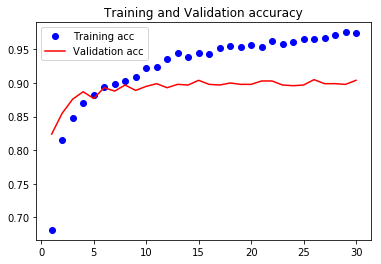

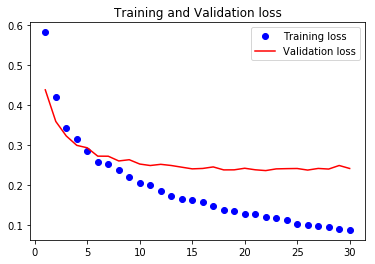

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure().patch.set_facecolor('xkcd:white')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure().patch.set_facecolor('xkcd:white')

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()
# 단순한 특성 추출 방식의 훈련 정확도와 검증 정확도
# 약 90%의 검증 정확도 확보
# but, 50%의 드롭아웃을 사용했음에호 훈련 초기부터 과대적합이 시작됨.
# 작은 이미지 데이터셋에서는 필수적으로 데이터 증식을 통해 과대적합을 방지해야 함

#### 데이터 증식을 사용한 특성 추출

In [11]:
# 위의 방법보다 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법을 사용할 수 있음
# conv_base 모델을 확장하고 입력 데이터를 사용하여 end-to-end로 실행
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 모델을 컴파일하고 훈련하기 전에 합성곱 기반 층을 동결하는 것이 중요
# 하나 이상의 층을 동결(freezing)한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻
# 동결하지 않으면 합성곱 기반 층에 의해 사전에 학습된 표현(미리 학습된 모델 like VGG16)이 훈련하는 동안 수정됨
# 맨 뒤의 Dense층은 랜덤하게 초기화되므로 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것이고, freezing 하지 않으면
# 이 값으로 인해 사전 학습된 표현이 크게 훼손됨
# In Keras, 'trainable = False' 로 설정하여 네트워크 동결

In [18]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수 : ', len(model.trainable_weights))
conv_base.trainable = False
print('conv_base를 동결한 후 훈련되는 가중치의 수 : ', len(model.trainable_weights))
# 추가한 2개의 Dense층 가중치만 훈련됨(층마다 2개 가중치 - 가중치 행렬 & 편향 벡터)
# ***** 변경 사항을 적용하려면 모델을 다시 컴파일해야 함 *****

conv_base를 동결하기 전 훈련되는 가중치의 수 :  30
conv_base를 동결한 후 훈련되는 가중치의 수 :  4


In [12]:
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras import optimizers

train_datagen = IDG(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = IDG(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

#history = model.fit_generator(
#    train_generator,
#    steps_per_epoch=100,
#    epochs=30,
#    validation_data=val_generator,
#    validation_steps=50,
#    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


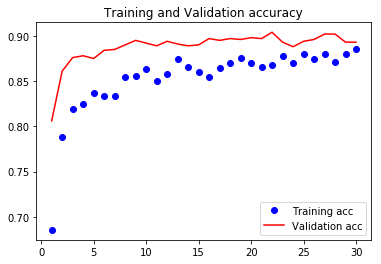

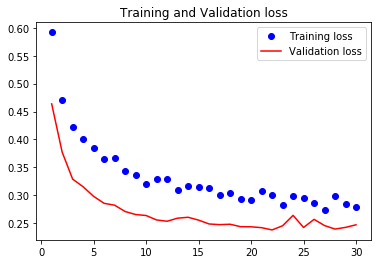

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure().patch.set_facecolor('xkcd:white')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure().patch.set_facecolor('xkcd:white')

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()
# 단순 특성 추출보다 훨씬 과대적합이 줄어듦
# val loss도 epoch가 20이 넘어갈 때 까지 지속적으로 감소 / val acc도 epoch 20 언저리까지 지속적으로 증가

## 5.3.2 미세 조정

1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크 추가
2. 기반 네트워크 동결
3. 새로 추가한 네트워크 훈련
4. 기반 네트워크에서 일부 층의 동결 해제
5. 동결 해제한 층과 새로 추가한 층을 함께 훈련

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [13]:
# 상위 3개 층, 즉 block5_conv1/2/3 을 동결 해제한 후 학습
# because, 하위층은 일반적인 특성을 인코딩하고 상위층일수록 좀 더 특화된 특성을 인코딩함.
# 새로운 문제애 재활용하도록 수정할 때는 구체적인 특성을 조정해주는 것이 필요하므로 상위 일부 층만 미세 조정하는 것이 유리.
# And, 하위층까지 미세 조정할 경우 과대적합의 위험이 커짐
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [14]:
# 학습률을 낮춘 RMSProp optimizer 사용. because, 미세 조정하는 3개 층에서 학습된 표현을 조금씩 수정하기 위해
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=val_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 17s 169ms/step - loss: 0.4168 - acc: 0.8015 - val_loss: 0.2500 - val_acc: 0.8870
Epoch 2/100
100/100 [==============================] - 15s 148ms/step - loss: 0.3135 - acc: 0.8645 - val_loss: 0.2214 - val_acc: 0.9000
Epoch 3/100
100/100 [==============================] - 15s 148ms/step - loss: 0.2872 - acc: 0.8765 - val_loss: 0.2083 - val_acc: 0.9100
Epoch 4/100
100/100 [==============================] - 16s 157ms/step - loss: 0.2695 - acc: 0.8885 - val_loss: 0.2032 - val_acc: 0.9090
Epoch 5/100
100/100 [==============================] - 15s 150ms/step - loss: 0.2444 - acc: 0.9045 - val_loss: 0.1938 - val_acc: 0.9210
Epoch 6/100
100/100 [==============================] - 15s 148ms/step - loss: 0.2325 - acc: 0.9090 - val_loss: 0.1905 - val_acc: 0.9210
Epoch 7/100
100/100 [==============================] - 15s 149ms/step - loss: 0.2212 - acc: 0.8995 - val_loss: 0.2134 - val_acc: 0.9100
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 16s 160ms/step - loss: 0.0478 - acc: 0.9825 - val_loss: 0.2053 - val_acc: 0.9420
Epoch 62/100
100/100 [==============================] - 15s 154ms/step - loss: 0.0501 - acc: 0.9825 - val_loss: 0.2058 - val_acc: 0.9420
Epoch 63/100
100/100 [==============================] - 15s 154ms/step - loss: 0.0351 - acc: 0.9895 - val_loss: 0.2581 - val_acc: 0.9290
Epoch 64/100
100/100 [==============================] - 15s 155ms/step - loss: 0.0394 - acc: 0.9835 - val_loss: 0.2018 - val_acc: 0.9440
Epoch 65/100
100/100 [==============================] - 16s 160ms/step - loss: 0.0387 - acc: 0.9835 - val_loss: 0.2180 - val_acc: 0.9340
Epoch 66/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0357 - acc: 0.9865 - val_loss: 0.2093 - val_acc: 0.9330
Epoch 67/100
100/100 [==============================] - 17s 166ms/step - loss: 0.0390 - acc: 0.9865 - val_loss: 0.1773 - val_acc: 0.9430
Epoch 68/100
100/100 [===================

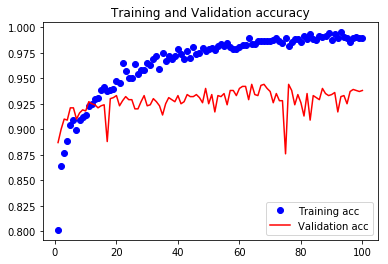

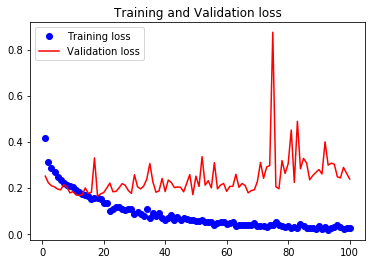

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure().patch.set_facecolor('xkcd:white')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure().patch.set_facecolor('xkcd:white')

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

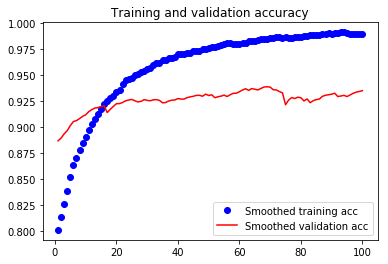

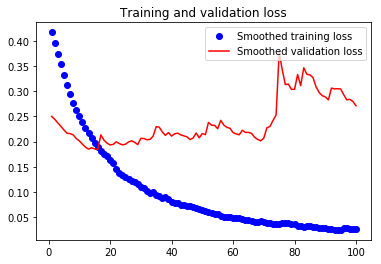

In [17]:
# 지수 이동평균으로 부드러운 그래프 그리기

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.figure().patch.set_facecolor('xkcd:white')
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'r', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure().patch.set_facecolor('xkcd:white')
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 손실 곡선은 오히려 악화되었다고 볼 수도 있음
- 손실이 감소되지 않았는데 정확도가 안정되거나 향상된 이유?
    - 그래프는 개별적 손실 값의 평균을 그린 것이지만 정확도에 영향을 미치는 것은 손실 값의 평균이 아닌 '분포'임
    - 즉, 모델이 더 향상되더라도 평균 손실에 반영되지 않을 수 있음

In [18]:
# 테스트 데이터에서 모델 평가
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc: ', test_acc)

Found 1000 images belonging to 2 classes.
test acc:  0.9459999907016754


# 5.4 컨브넷 학습 시각화

- 컨브넷 중간층의 출력(중간층에 있는 활성화)을 시각화하기


- 컨브넷 필터를 시각화 하기 : 필터가 찾으려는 시각적 패턴과 개념을 이해하는데 도움


- 클래스 활성화에 대한 히트맵을 이미지에 시각화하기 : 이미지의 어느 부분이 주어진 클래스에 속하는데 기여했는지 이해 가능 & 객체 위치 추정

## 5.4.1 중간층의 활성화 시각화하기

In [20]:
# 5.2절에서 저장했던 모델 로드하여 사용
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [21]:
# 네트워크 훈련할 때 사용했던 이미지에 포함되지 않은 고양이 사진 하나를 입력 이미지로 선택
img_path = './datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) # 이미지를 4D 텐서로 변경(입력 데이터의 첫 번째 차원은 배치 차원) reshape도 사용가능
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


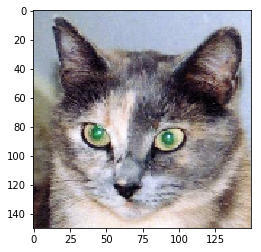

In [23]:
import matplotlib.pyplot as plt

plt.figure().patch.set_facecolor('xkcd:white')
plt.imshow(img_tensor[0])
plt.show()

In [29]:
# 확인하고 싶은 특성 맵 추출하기 위해 이미지 배치를 입력받아 모든 합성곱과 풀링 층의 활성화를 출력하는 케라스 모델을 만듦
# 케라스의 Model 클래스 사용
# 입/출력 텐서 2개 매개변수 필요
# 반환되는 객체는 Sequential과 같은 케라스 모델이지만 특정 입력과 특정 출력을 매칭함
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] # 상위 8개 층의 출력을 추출
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# 다중 출력 모델 : 하나의 입력과 층의 활성화마다 하나씩 총 8개의 출력을 가짐
activations = activation_model.predict(img_tensor)

In [30]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


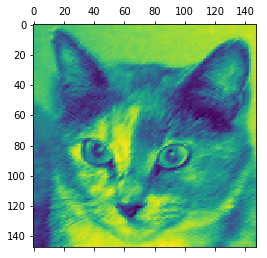

In [32]:
plt.matshow(first_layer_activation[0, :,:,19], cmap='viridis') # 첫 번째 층 활성화 중 20번째 채널

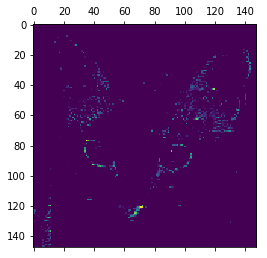

In [33]:
plt.matshow(first_layer_activation[0,:,:,15], cmap='viridis') # 첫 번째 층 활성화 중 16번째 채널

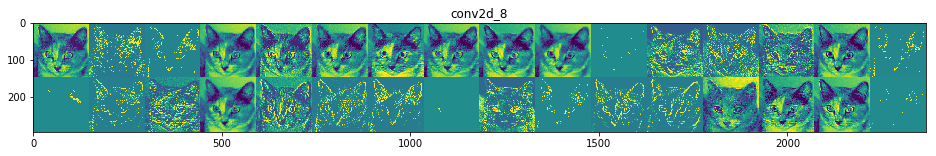

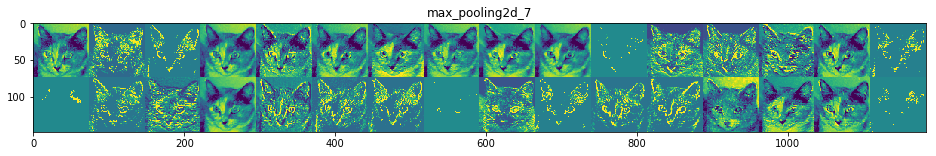

C:\Users\User\Anaconda3\envs\tensorflow36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


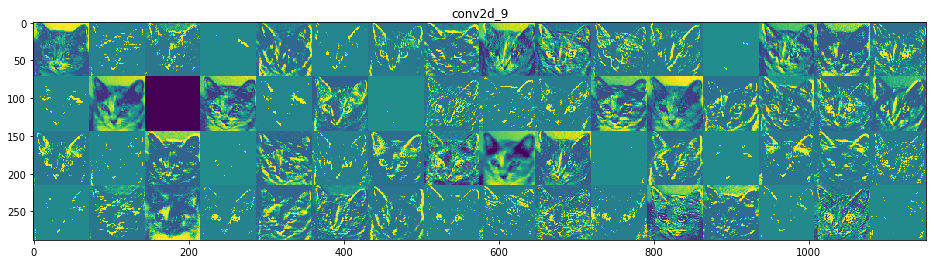

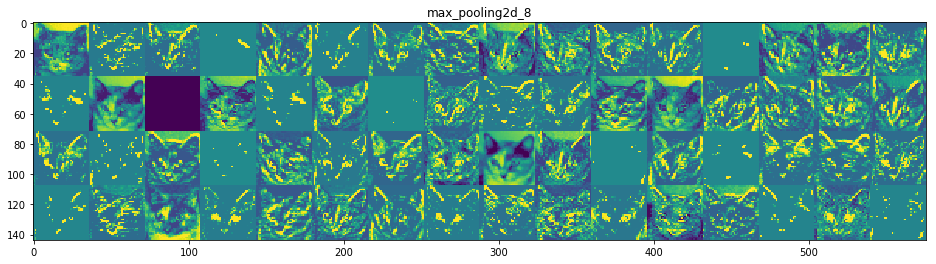

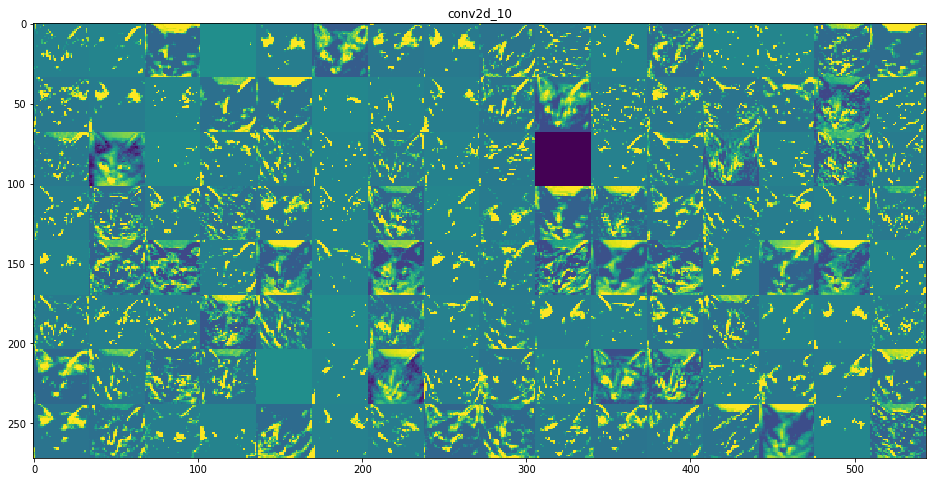

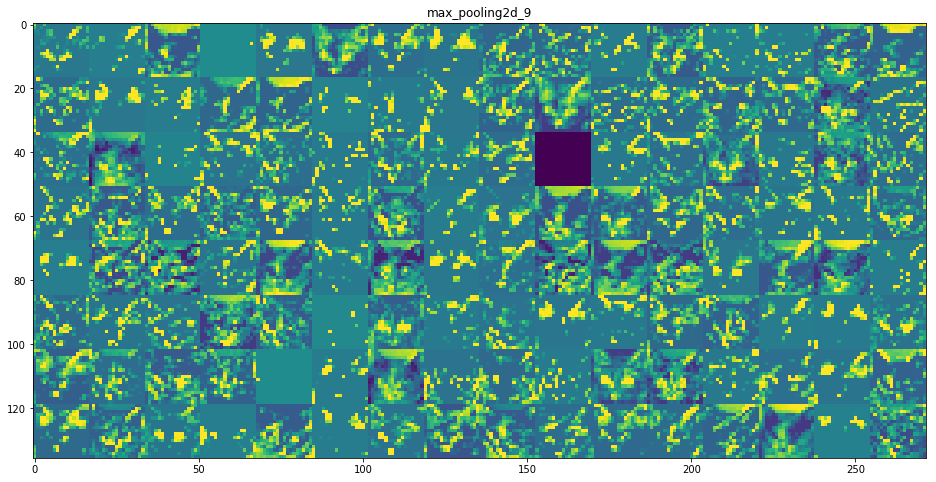

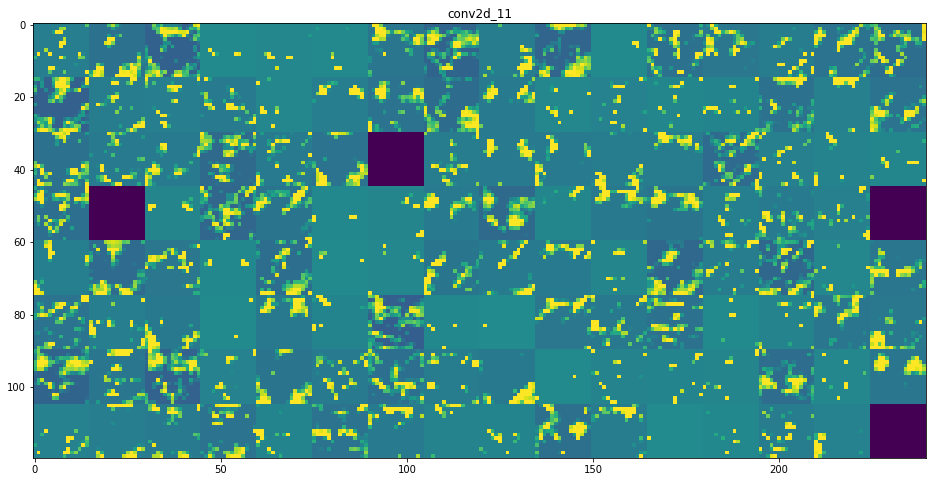

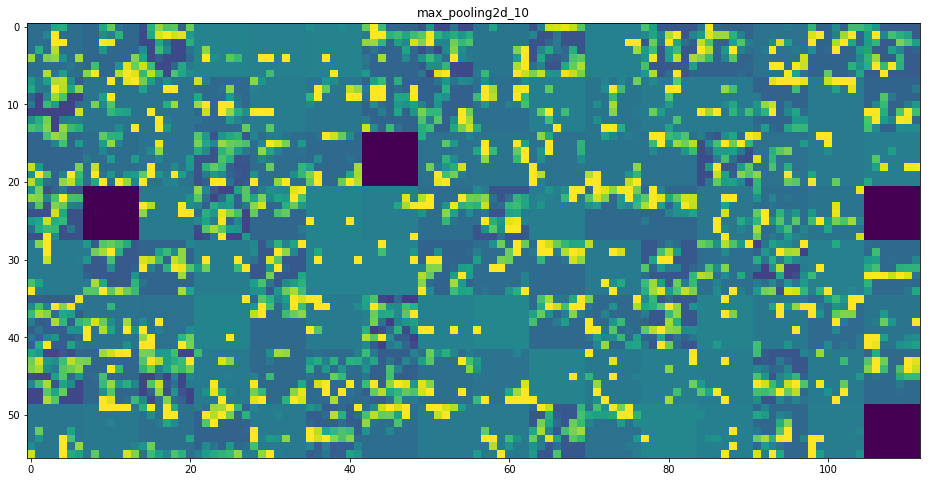

In [34]:
# 중간층의 모든 활성화에 있는 채널 시각화 하기
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] # 특성 맵에 있는 특성의 수
    
    size = layer_activation.shape[1] # 특성맵의 크기는 (1, size, size, n_features)
    
    n_cols = n_features // images_per_row # 활성화 채널을 위한 그리드 크기
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # 임의의 실수인 층의 출력을 픽셀로 표현 가능한 0~255 사이 정수로 바꿈.
    # standard score화 시키고 2.0 이내의 값(약 95%)들이 0~255 사이에 놓이도록 증폭한 후 클리핑(?)
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                        row *size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                       scale * display_grid.shape[0])).patch.set_facecolor('xkcd:white')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
    plt.show()

## 5.4.2 컨브넷 필터 시각화하기

- 각 필터가 반응하는 시각적 패턴 그려보기
    - 빈 입력 이미지에서 시작해서 특정 필터의 응답을 최대화하기 위해 컨브넷 입력 이미지에 경사 상승법 적용  
      (손실 함수의 값이 커지는 방향으로 그래디언트 업데이트)
    - 결과적으로 입력 이미지는 선택된 필터가 최대로 응답하는 이미지

In [2]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
             include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:, filter_index])

In [6]:
# 경사 상승법 구현을 위해 모델의 입력에 대한 손실의 Gradient가 필요. 케라스 backend 모듈의 gradients 함수 이용
grads = K.gradients(loss, model.input)[0]

# 경사 상승법을 부드럽게 하기 위해 Gradient tensor를 L2 Norm(텐서 제곱한 값들 합하고 제곱근)으로 나누어 정규화.
# -> 입력 이미지에 적용할 수정량의 크기를 항상 일정 범위 안에 놓을 수 있음 a.k.a Gradient Clipping
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # 0 나눗셈 방지를 위해 

# 주어진 입력 이미지에 대해 손실 텐서와 그래디언트 텐서 계산
# iterate는 넘파이 텐서(크기가 1인 텐서의 리스트)를 입력으로 받아 손실과 그래디언트 2개의 넘파이 텐서를 반환.
# 경사 상승법을 사용하므로 keras.optimizers 모듈에 있는 옵티마이저는 사용 불가. 직접 구현해야 함.
# keras.backend.function() 함수는 입력값을 받아 지정된 출력 텐서들을 얻을 수 있는 객체를 만들어 줌.
iterate = K.function([model.input],[loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [7]:
# python loop를 만들어 확률적 경사 상승법 구성
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128. # + 128. = 잡음 섞인 회색 이미지 만들기

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step # 손실 최대화 하는 방향으로 입력 이미지 수정

In [8]:
# 결과 이미지 텐서는 (1, 150, 150, 3) 크기의 부동 소수 텐서로 [0,255] 사이의 정수가 아님.
# 출력 가능한 이미지로 변경하기 위해 후처리 필요
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x+= 0.5
    X = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [9]:
# 위의 코드들을 모아서 층의 이름과 필터 번호를 입력받아 필터 활성화를 최대화하는 패턴을 이미지 텐서로 출력하는 함수 코드 작성
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

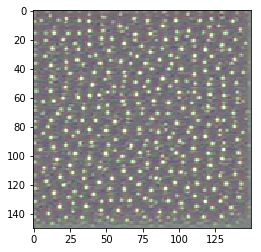

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure().patch.set_facecolor('xkcd:white')
plt.imshow(generate_pattern('block3_conv1', 0))

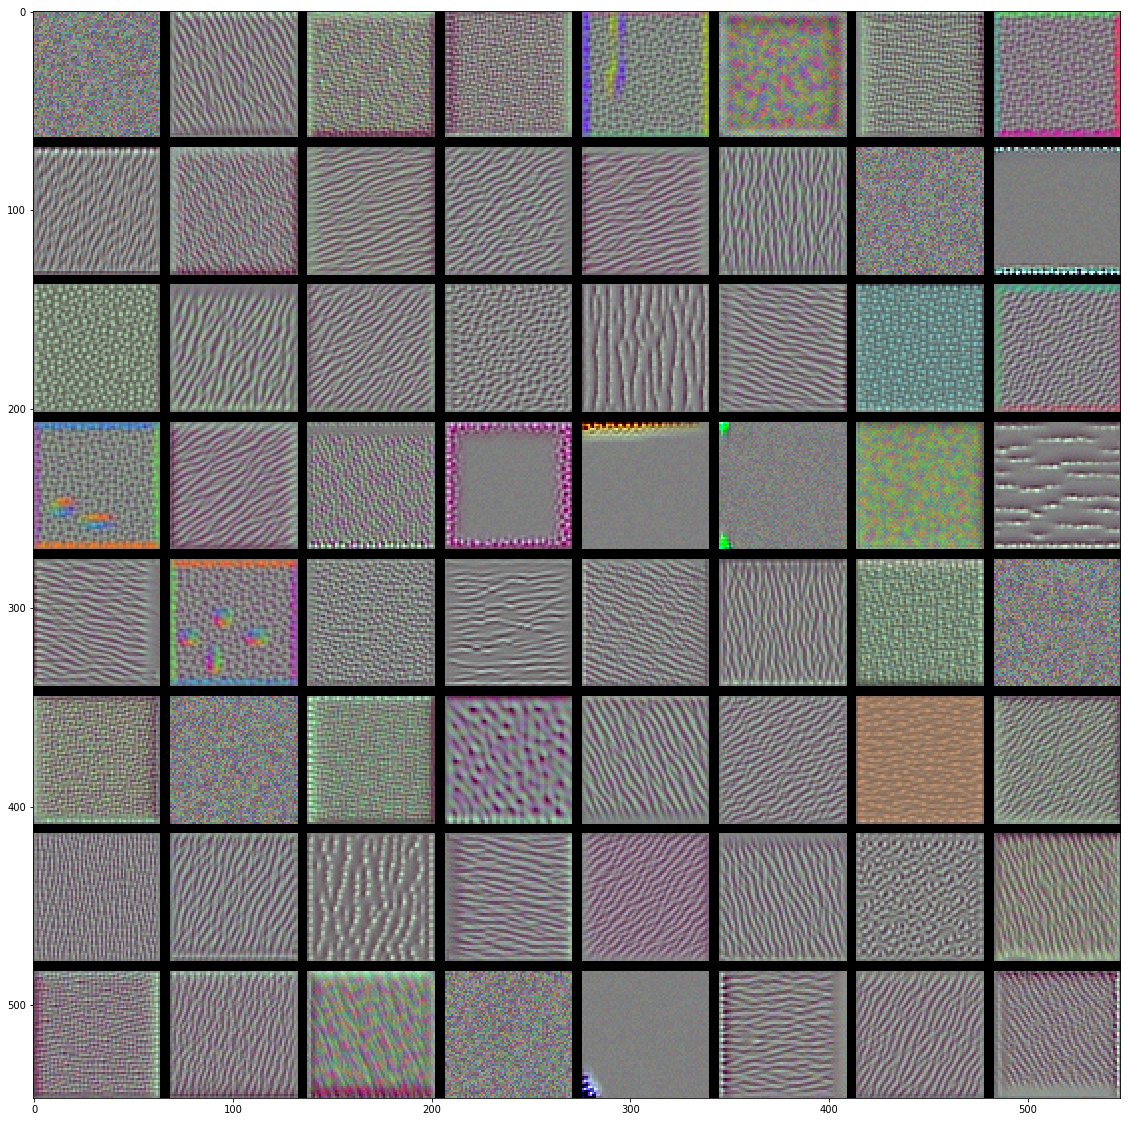

In [15]:
# 모든 층에 있는 필터 시각화
layer_name = 'block2_conv1'
size = 64
margin = 5

results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 3), dtype='uint8')

for i in range(8): # results 그리드의 행 반복
    for j in range(8): # results 그리드의 열 반복
        filter_img = generate_pattern(layer_name, i + (j*8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img
        
plt.figure(figsize=(20,20)).patch.set_facecolor('xkcd:white')
plt.imshow(results)

## 5.4.3 클래스 활성화의 히트맵 시각화하기

- 이미지의 어느 부분이 컨브넷의 최종 분류 결정에 기여하는지 보여주는 시각화
- 분류에 실수가 있는 경우 컨브넷 결정 과정 디버깅하는 데에도 도움이 됨
- 또한, 이미지에 특정 물체가 있는 위치를 파악하는 데 사용할 수도 있음

In [16]:
# a.k.a Class Activation Map(CAM - 클래스 활성화 맵)
# Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
# 입력 이미지가 주어지면 합성곱 층에 있는 특성 맵의 출력을 추출
# 특성 맵의 모든 채널 출력에 채널에 대한 클래스의 그래디언트 평균을 곱함
# -> 즉, 입력 이미지가 각 채널을 활성화하는 정도에 대한 공간적인 맵을 클래스에 대한 각 채널의 중요도로 가중치 부여하여
#    입력 이미지가 클래스를 활성화하는 정도에 대한 공간적인 맵을 만드는 것.

from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet') # 최상단의 fully connected layer(Dense)도 포함시킴

553467904/553467096 [==============================] - 354s 1us/step


In [18]:
# VGG16을 위해 입력 이미지 전처리
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './datasets/creative_commons_elephant.jpg'

img = image.load_img(img_path,target_size=(224, 224))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0) # 차원 추가하여 (1, 224, 224, 3) 크기의 배치로 배열을 변환

x = preprocess_input(x) # 데이터 전처리(채널별 컬러 정규화 수행)

In [19]:
preds = model.predict(x)
print("Predicted: ", decode_predictions(preds, top=3)[0])
# 아프리카 코끼리 91% 예측

40960/35363 [==================================] - 0s 5us/step
Predicted:  [('n02504458', 'African_elephant', 0.9101744), ('n01871265', 'tusker', 0.08544522), ('n02504013', 'Indian_elephant', 0.0043368954)]


In [20]:
np.argmax(preds[0]) # 아프리카 코끼리 클래스 인덱스 = 386

386

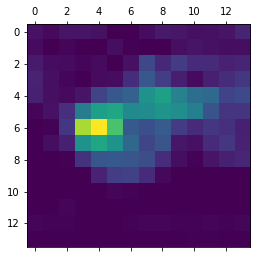

In [21]:
# 이미지에서 가장 아프리카 코끼리 같은 부위를 시각화 by Grad-CAM
african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
# block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
pooled_grads = K.mean(grads, axis=(0,1,2)) # 특성 맵 채널별 그래디언트 평균값이 담긴 (512,) 크기의 백터

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
# 샘플 이미지가 주어졌을 때, 위에서 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구함
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512): # '아프리카 코끼리' 클래스에 대한 '채널의 중요도'를 특성 맵 배열의 채널에 곱함
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i] 
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
# 시각화 위해 히트맵 0~1 사이 정규화
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [23]:
# opencv를 사용하여 위의 히트맵에 원본 이미지를 겹친 이미지 만들기
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # 원본 이미지 크기에 맞게 변경
heatmap = np.uint8(255 * heatmap) # heatmap RGB 포맷으로 변환
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img # 0.4 = 히트맵 강도
cv2.imwrite('./datasets/elephant_cam.jpg', superimposed_img)

True